In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess
from glob import glob
import re

# Runtime comparison between swift zoom and arepo

In [2]:
from unyt import ms, hour
def get_timesteps(timesteps_file):
    f = np.genfromtxt(timesteps_file, usecols=(2,12), invalid_raise = False)

    a = f[:,0] # Scale-factor
    t = f[:,1] #* ms # Wallclock time
    #t = np.cumsum(t).to(hour)
    return a, t

#filename = "/cosma7/data/dp004/dc-kott1/swift-zoom_single-node_vol03_lp1/timesteps_112.txt"
filename = "/cosma7/data/dp004/dc-kott1/swift/vol03_lp1_results/timesteps_112.txt"
a, swift_t_base = get_timesteps(filename)
swift_t = swift_t_base * ms
swift_t = np.cumsum(swift_t).to(hour)
#arepo
#arepo_df = pd.read_csv("/cosma7/data/dp004/dc-kott1/arepo_results/vol03_lp1_512mesh/output/wallclock.txt", delimiter='\t', index_col = 0)
arepo_df = pd.read_csv("/cosma7/data/dp004/dc-kott1/arepo_results/vol03_lp1/output/wallclock.txt", delimiter='\t', index_col = 0)
arepo_t = arepo_df['Wallclock']/3600

Text(0.5, 1.0, 'Resolution: $10^4 M_{\\odot}$; No. CPUs: 112; Volume: $5 Mpc$')

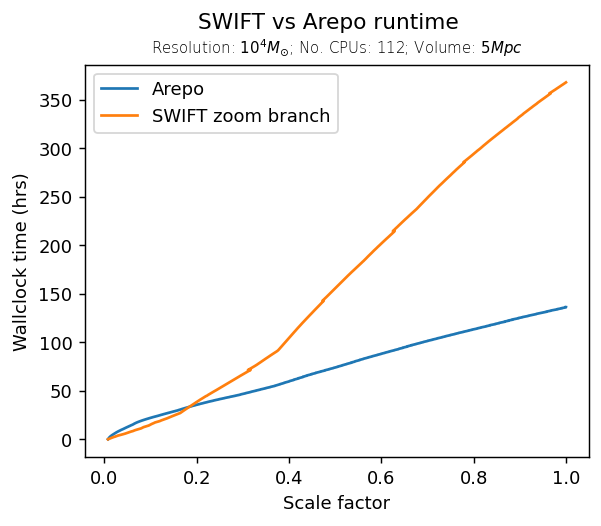

In [3]:
plt.figure(dpi = 130, figsize=(5,4))
plt.plot(arepo_df['Time'], arepo_t, label='Arepo')
plt.plot(a, swift_t, label = 'SWIFT zoom branch')
plt.ylabel('Wallclock time (hrs)')
plt.xlabel('Scale factor')
plt.legend()
plt.suptitle('SWIFT vs Arepo runtime')
plt.title(r'Resolution: $10^4 M_{\odot}$; No. CPUs: 112; Volume: $5 Mpc$', fontsize='small', fontweight='light')

# Analyse tasks

## Arepo

In [4]:
# Initialize variables to store parsed data
data = []

# Open the file and read line by line
with open('/cosma7/data/dp004/dc-kott1/arepo_results/vol03_lp1_512mesh/output/cpu.txt', 'r') as file:
    for line in file:
        # Check if the line contains 'Step' to indicate the start of a new section
        if line.startswith('Step'):
            # Extract relevant information from the line
            step_info = line.split(',')
            step_number = int(step_info[0].split()[1])
            time = float(step_info[1].split(':')[1])
            #cpus = int(step_info[2].split(':')[1])
            multi_domains = int(step_info[3].split(':')[1])
            highest_active_time_bin = int(step_info[4].split(':')[1])
            # Append the parsed data as a dictionary to the 'data' list
            data.append({
                'Step': step_number,
                'Time': time,
                #'CPUs': cpus,
                'MultiDomains': multi_domains,
                'HighestActiveTimeBin': highest_active_time_bin,
                'Details': []
            })
        elif line.strip() and not line.strip().startswith('diff'):  # Check if the line is not empty and does not start with 'diff' or 'total'
            # Extract detailed information from the line
            parts = line.split()
            name = ' '.join(parts[:-4])  # Join all parts except the last three
            diff_perc = parts[-3] if '%' not in parts[-3] else float(parts[-3].replace('%', ''))
            diff = parts[-4]
            cumulative_perc = parts[-1] if '%' not in parts[-1] else float(parts[-1].replace('%', ''))
            cumulative = parts[-2]
            
            diff = float(diff)
            cumulative = float(cumulative)
            
            # Append the detailed information as a dictionary to the 'Details' list of the last element in 'data'
            data[-1]['Details'].append({
                'Name': name,
                'Diff': diff,
                'Diff%': diff_perc,
                'Cumulative': cumulative,
                'Cumulative%': cumulative_perc
            })

In [5]:
df = pd.DataFrame(data)
df.set_index('Step', inplace = True)
df['Details'].iloc[0]

[{'Name': 'total',
  'Diff': 586.78,
  'Diff%': 100.0,
  'Cumulative': 586.78,
  'Cumulative%': 100.0},
 {'Name': 'treegrav',
  'Diff': 476.6,
  'Diff%': 81.2,
  'Cumulative': 476.6,
  'Cumulative%': 81.2},
 {'Name': 'treebuild',
  'Diff': 2.65,
  'Diff%': 0.5,
  'Cumulative': 2.65,
  'Cumulative%': 0.5},
 {'Name': 'insert',
  'Diff': 1.63,
  'Diff%': 0.3,
  'Cumulative': 1.63,
  'Cumulative%': 0.3},
 {'Name': 'branches',
  'Diff': 0.75,
  'Diff%': 0.1,
  'Cumulative': 0.75,
  'Cumulative%': 0.1},
 {'Name': 'toplevel',
  'Diff': 0.0,
  'Diff%': 0.0,
  'Cumulative': 0.0,
  'Cumulative%': 0.0},
 {'Name': 'treecostm',
  'Diff': 0.71,
  'Diff%': 0.1,
  'Cumulative': 0.71,
  'Cumulative%': 0.1},
 {'Name': 'treewalk',
  'Diff': 268.41,
  'Diff%': 45.7,
  'Cumulative': 268.41,
  'Cumulative%': 45.7},
 {'Name': 'treewalk1',
  'Diff': 169.86,
  'Diff%': 28.9,
  'Cumulative': 169.86,
  'Cumulative%': 28.9},
 {'Name': 'treewalk2',
  'Diff': 98.55,
  'Diff%': 16.8,
  'Cumulative': 98.55,
  'Cumula

### How much time does each sub calculation take in comparison to the total?

In [6]:
# Initialize an empty list to store the results
top_names = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Filter out the rows with the name "total"
    filtered_details = [detail for detail in row['Details'] if detail['Name'] != 'restart']
    if filtered_details:
        # Sort the filtered "Details" based on "Diff" in descending order
        sorted_details = sorted(filtered_details, key=lambda x: x['Diff'], reverse=True)
        # Select the top 5 names based on "Diff"
        top_5_details = sorted_details[:3]
        # Append the top 5 names to the results list
        for detail in top_5_details:
            top_names.append((index, detail['Name'], detail['Diff']))

# Convert the results to a DataFrame
top_names_df = pd.DataFrame(top_names, columns=['Step', 'Name', 'Diff'])

top_names_df['Name'].unique()

array(['total', 'treegrav', 'treewalk', 'domain', 'peano', 'fof',
       'treeimbal', 'subfind', 'misc'], dtype=object)

In [7]:
# List of unique top names
unique_top_names = ['total', 'treegrav', 'treewalk', 'domain', 'treeimbal']

# Dictionary to store the values for each top name
top_values_dict = {name: {'Step': [], 'Cumulative': [], 'Cumulative%': []} for name in unique_top_names}

# Iterate over each step and extract values for each top name
for step in df.index:
    for name in unique_top_names:
        detail = next((detail for detail in df.at[step, 'Details'] if detail['Name'] == name), None)
        if detail:
            top_values_dict[name]['Step'].append(step)
            top_values_dict[name]['Cumulative'].append(detail['Cumulative'])
            top_values_dict[name]['Cumulative%'].append(detail['Cumulative%'])

# Create a DataFrame for each top name
top_values_dfs = {name: pd.DataFrame(data) for name, data in top_values_dict.items()}

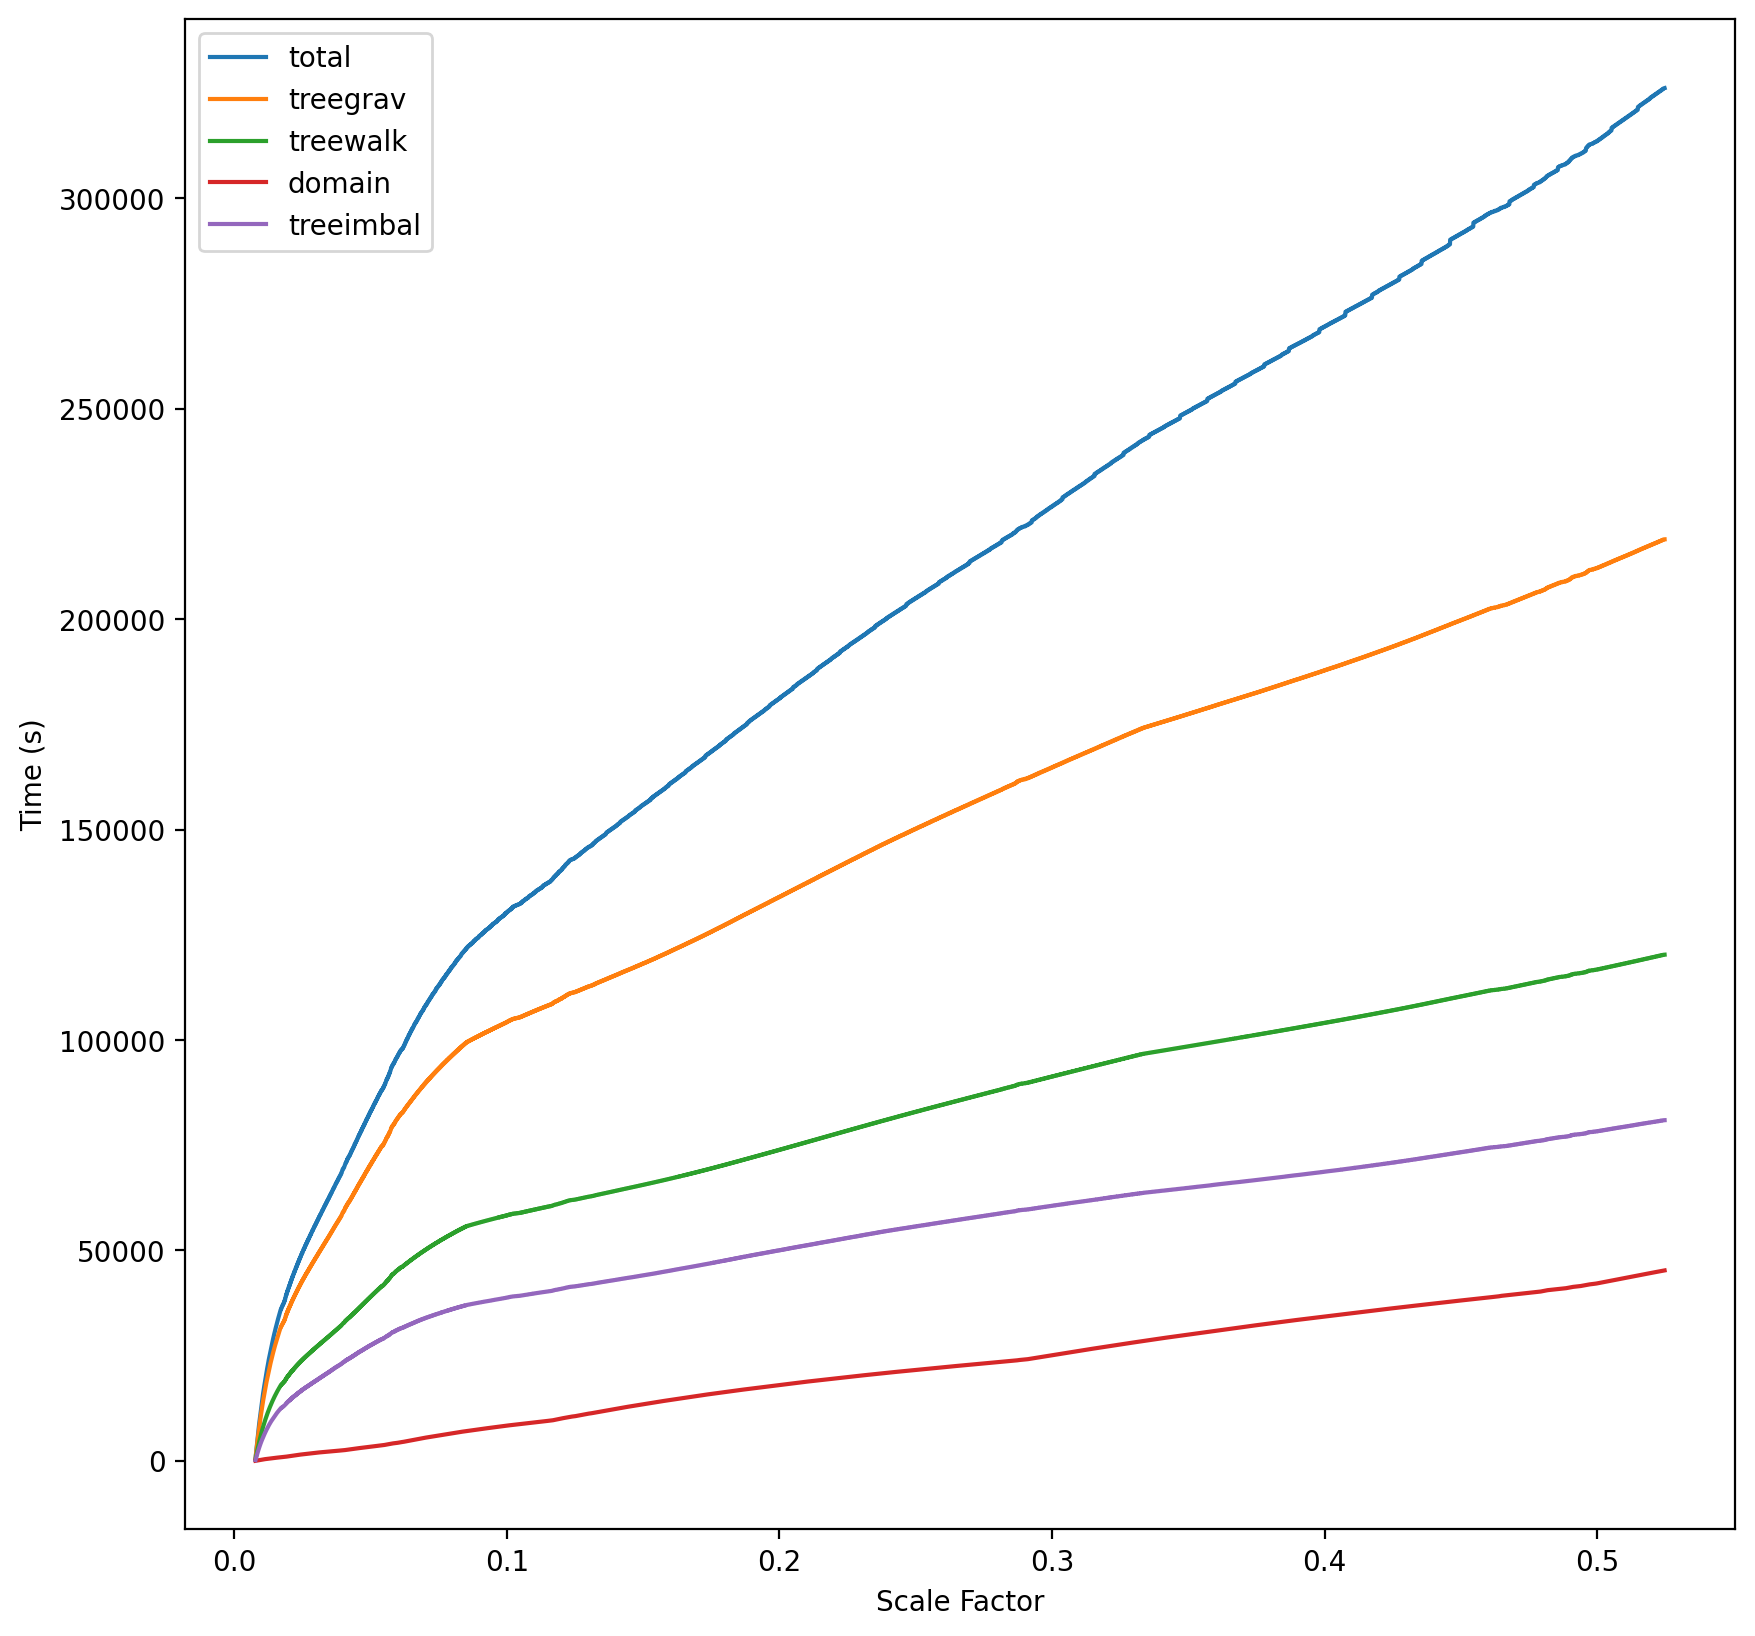

In [8]:
plt.figure(figsize = (10,10), dpi = 200)
#plt.plot(df.index.values, df['Time'], label='total')
for name, top_df in top_values_dfs.items():
    plt.plot(np.array(arepo_df['Time'])[np.array(top_values_dfs.get('total')['Step'])], top_df['Cumulative'], label=name)
plt.xlabel('Scale Factor')
plt.ylabel('Time (s)')
plt.legend()
#plt.xlim(550,600)
plt.show()

# SWIFT Task analysis

In [9]:
#analysis tools paths
python_plot_tools_path = "/cosma/home/dp004/dc-kott1/swiftsim/tools/task_plots/"
analyse_tasks = os.path.join(python_plot_tools_path, "analyse_tasks.py")
plot_tasks = os.path.join(python_plot_tools_path, "plot_tasks.py")
plot_task_dependencies = os.path.join(python_plot_tools_path, "plot_tasks_dependencies.py")

#thread tasks data tables
thread_dat_files = glob("/cosma7/data/dp004/dc-kott1/swift-zoom_single-node_vol03_lp1/thread_stats-step*.dat")

In [10]:
ex_data = np.loadtxt("/cosma7/data/dp004/dc-kott1/swift-zoom_single-node_vol03_lp1/thread_stats-step3403.dat", dtype=str, skiprows=1)
column_names = ['task', 'ntasks', 'min', 'max', 'sum', 'mean', 'percent', 'mintic', 'maxtic', 'meantic', 'fixed_cost']
# Remove the first row (column names) from the data array
swift_df = pd.DataFrame(ex_data,  columns = column_names)
swift_df[swift_df.columns[1:]] = swift_df[swift_df.columns[1:]].astype(float)
top_tasks_swift = list(swift_df.sort_values(by='percent', ascending=False)['task'].iloc[:5])
swift_df
#print(top_tasks_swift)
#print(swift_df.sort_values(by='percent', ascending=False))

,task,ntasks,min,max,sum,mean,percent,mintic,maxtic,meantic,fixed_cost
0,self/grav,28.0,0.2304,202.2414,1119.3736,39.9776,6.9925,28742.5507,29814.3038,29377.3421,399776.0
1,pair/grav,3438.0,0.0045,72.0852,4693.1420,1.3651,29.3170,28693.0756,31531.0688,29494.9569,13650.0
2,pair/grav_zoombuff,80.0,0.0074,1.8736,21.1602,0.2645,0.1322,31335.8707,31410.6013,31393.2496,2645.0
3,pair/grav_zoombkg,478.0,0.0049,27.9855,141.4680,0.2960,0.8837,28695.5793,32185.2575,31074.2076,2959.0
4,init_grav/none,4.0,0.1194,0.9507,2.0291,0.5073,0.0127,28680.1427,29436.4298,29011.7500,5072.0
5,drift_gpart/none,135.0,0.0234,79.7377,336.3933,2.4918,2.1014,28680.1134,29460.0226,29306.1370,24918.0
6,drift_gpart_bkg/none,10.0,1.2329,199.5410,426.2664,42.6266,2.6628,28680.1580,29451.0389,29248.9164,426266.0
7,kick1/none,4.0,0.0279,3.7281,4.9335,1.2334,0.0308,31428.2740,32198.0285,31649.5143,12333.0
8,kick2/none,4.0,0.0733,2.6114,4.1007,1.0252,0.0256,31426.9390,32191.6185,31646.9899,10251.0
9,timestep/none,4.0,0.1186,3.7898,5.9366,1.4842,0.0371,31427.6285,32194.2378,31648.0272,14841.0


In [11]:
# task ntasks min max sum mean percent mintic maxtic meantic fixed_cost
# Load the text file into a numpy array
top_tasks_swift = ['self/grav', 'pair/grav', 'grav_mm/none', 'recv/tend', 'drift_gpart_bkg/none']#, 'pair/grav_zoombkg']
swift_info = {name: {'step': [], 'ntasks': [], 'cputime': [], 'percent': []} for name in top_tasks_swift}
for file in thread_dat_files:
    # Define a regular expression pattern to match the "step" and subsequent numbers
    pattern = r'step(\d+)'

    # Use re.search to find the pattern in the filename
    match = re.search(pattern, file)

    # If a match is found, extract the "step" and subsequent numbers
    if match:
        step_num = int(match.group(1))
    
    data = np.loadtxt(file, dtype=str, skiprows=1)
    thread_df = pd.DataFrame(data,  columns = column_names)
    # Convert numeric columns to float
    numeric_cols = ['ntasks', 'min', 'max', 'sum', 'mean', 'percent', 'mintic', 'maxtic', 'meantic', 'fixed_cost']
    thread_df[numeric_cols] = thread_df[numeric_cols].astype(float)
    cpu_time = (thread_df['maxtic']-thread_df['mintic'])
    thread_df.insert(df.shape[1], 'cputime', cpu_time)
    for name in top_tasks_swift:
        swift_info[name]['step'].append(step_num)
        swift_info[name]['ntasks'].append(int(thread_df[thread_df['task'] == name]['ntasks']))
        swift_info[name]['cputime'].append(float(thread_df[thread_df['task'] == name]['cputime']))
        swift_info[name]['percent'].append(float(thread_df[thread_df['task'] == name]['percent']))
        
for name in swift_info:
    sorted_indices = np.argsort(swift_info[name]['step'])
    swift_info[name] = {key: [value[i] for i in sorted_indices] for key, value in swift_info[name].items()}

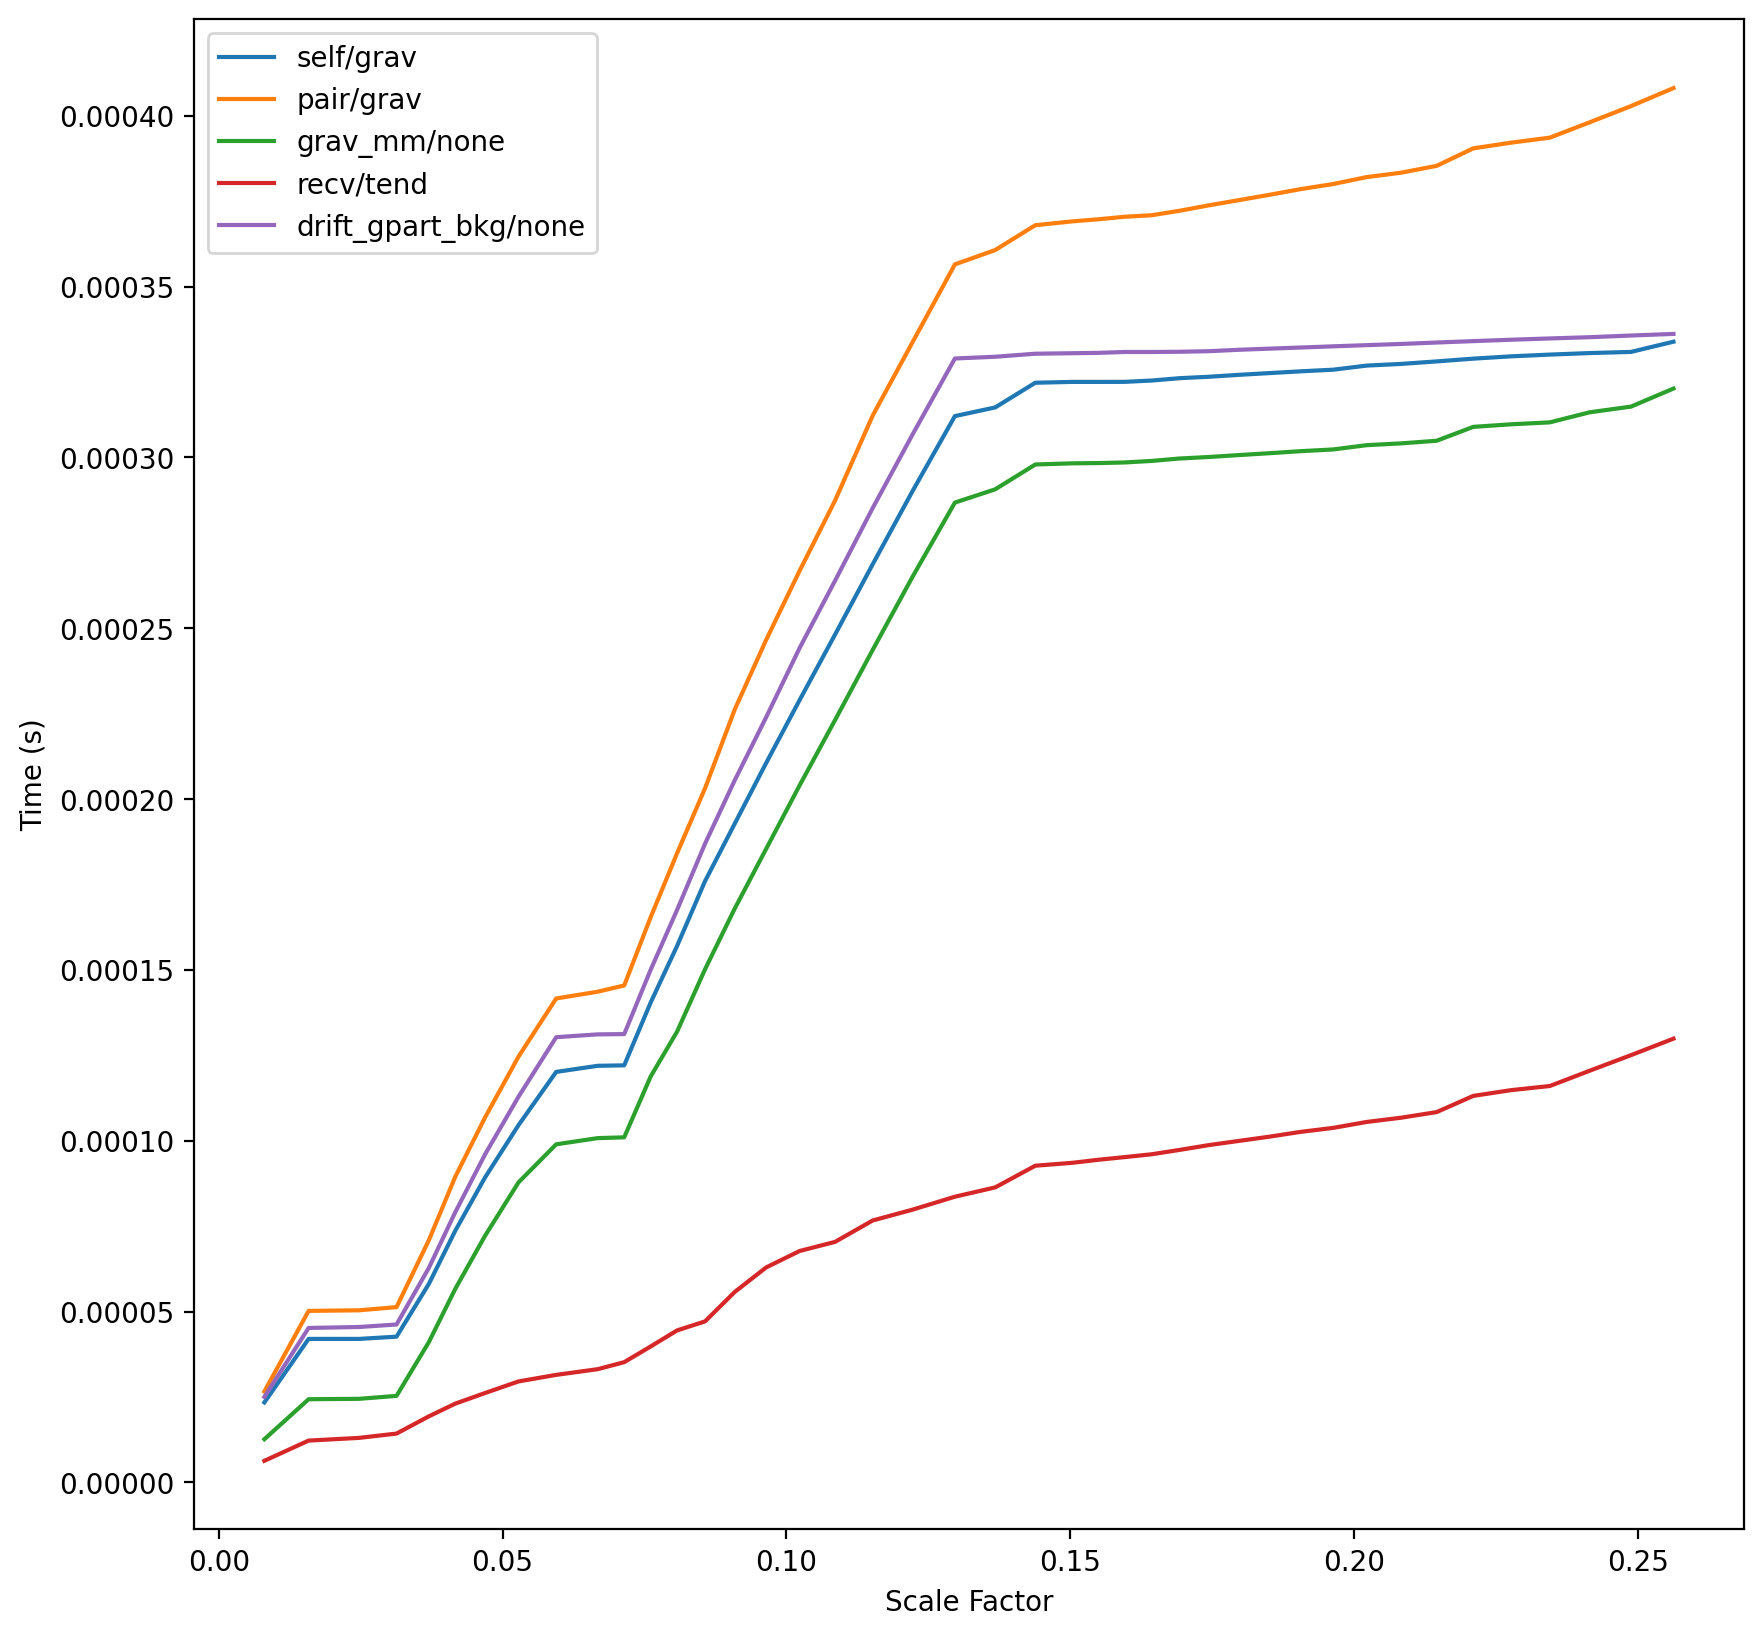

In [12]:
plt.figure(figsize = (10,10), dpi = 200)
#plt.plot(df.index.values, df['Time'], label='total')
for name, top_df in swift_info.items():
    plt.plot(np.array(a)[np.array(top_df['step'])], np.cumsum(top_df['cputime'])/2194846694, label=name)
    
#plt.plot(a, np.cumsum(swift_t_base), label = 'total')
plt.xlabel('Scale Factor')
plt.ylabel('Time (s)')
plt.legend()
plt.show()